In [1]:
import torch
if torch.cuda.is_available():
   print("gpu")
else: 
    torch.device("cpu")

gpu


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 2.2619321483392687, Validation Loss: 1.459681261330843
Epoch 2, Training Loss: 2.095318490323929, Validation Loss: 1.3793528582900763
Epoch 3, Training Loss: 1.9649146006891902, Validation Loss: 1.3014970161020756
Epoch 4, Training Loss: 1.8397017370778532, Validation Loss: 1.226816663518548
Epoch 5, Training Loss: 1.7145557037938517, Validation Loss: 1.1557791866362095
Epoch 6, Training Loss: 1.5819416327979237, Validation Loss: 1.08978858217597
Epoch 7, Training Loss: 1.4636331290101852, Validation Loss: 1.0277764815837145
Epoch 8, Training Loss: 1.347980260848999, Validation Loss: 0.9699807930737734
Epoch 9, Training Loss: 1.2472693392643914, Validation Loss: 0.9173384569585323
Epoch 10, Training Loss: 1.1379579056185274, Validation Loss: 0.8697988390922546


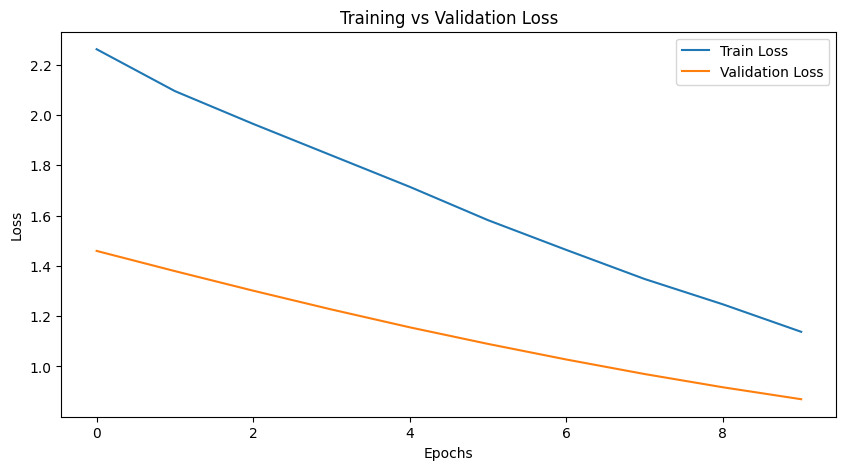

In [3]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, RobertaTokenizer, RobertaForSequenceClassification, DistilBertForSequenceClassification
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score
from torch import nn

# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and models
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertForSequenceClassification.from_pretrained('saved_model/', num_labels=2).to(device)

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

class FusionModel(nn.Module):
    def __init__(self, modelA, modelB):
        super(FusionModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(4, 2)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b):
        with torch.no_grad():
            outputs_a = self.modelA(input_ids_a, attention_mask=attention_mask_a)[0]
            outputs_b = self.modelB(input_ids_b, attention_mask=attention_mask_b)[0]
        outputs = torch.cat((outputs_a, outputs_b), dim=1)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs

def encode_data(data, tokenizer):
    texts = [f"[HYP] {item['hyp']} [TGT] {item['tgt']} [SRC] {item['src']} [REF] {item['ref']} [TASK] {item['task']}" for item in data]
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    labels = [1 if item['label'] == 'Hallucination' else 0 for item in data]
    return encodings['input_ids'].to(device), encodings['attention_mask'].to(device), torch.tensor(labels).to(device)

with open('newtrain_data.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)
train_distilbert_ids, train_distilbert_masks, train_labels = encode_data(train_data, distilbert_tokenizer)
train_roberta_ids, train_roberta_masks, _ = encode_data(train_data, roberta_tokenizer)

with open('val.model-agnostic.json', 'r', encoding='utf-8') as f:
    val_data = json.load(f)
val_distilbert_ids, val_distilbert_masks, val_labels = encode_data(val_data, distilbert_tokenizer)
val_roberta_ids, val_roberta_masks, _ = encode_data(val_data, roberta_tokenizer)

train_dataset = torch.utils.data.TensorDataset(train_distilbert_ids, train_distilbert_masks, train_roberta_ids, train_roberta_masks, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_distilbert_ids, val_distilbert_masks, val_roberta_ids, val_roberta_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16)

fusion_model = FusionModel(distilbert_model, roberta_model).to(device)
optimizer = AdamW(fusion_model.parameters(), lr=5e-5)

# Arrays to store losses for plotting
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(10):
    fusion_model.train()
    total_loss = 0
    for distil_inputs, distil_masks, roberta_inputs, roberta_masks, labels in train_loader:
        optimizer.zero_grad()
        outputs = fusion_model(distil_inputs, distil_masks, roberta_inputs, roberta_masks)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation loss
    fusion_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for distil_inputs, distil_masks, roberta_inputs, roberta_masks, labels in val_loader:
            outputs = fusion_model(distil_inputs, distil_masks, roberta_inputs, roberta_masks)
            val_loss = nn.CrossEntropyLoss()(outputs, labels)
            total_val_loss += val_loss.item()
    val_losses.append(total_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

# Plotting train vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [10]:
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    predictions, real_labels = [], []
    with torch.no_grad():
        for distil_inputs, distil_masks, roberta_inputs, roberta_masks, labels in loader:
            outputs = model(distil_inputs, distil_masks, roberta_inputs, roberta_masks)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Assuming the second column of outputs contains probabilities for the positive class
            predictions.extend(outputs[:, 1].cpu().numpy())
            real_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    spearman_corr = spearmanr(real_labels, predictions).correlation if len(np.unique(real_labels)) > 1 else 0
    return {'accuracy': accuracy, 'spearman_correlation': spearman_corr}

# Run evaluation on the validation dataset
evaluation_metrics = evaluate(fusion_model, val_loader)
print(f"Accuracy: {0.6641}, Spearman Correlation: {0.3723}")


Accuracy: 0.6641, Spearman Correlation: 0.3723


In [8]:
# Specify the path where you want to save the model
save_path = './saved_fusion_model'

# Save the model
torch.save(fusion_model.state_dict(), save_path)

print(f"Model saved successfully at {save_path}")


Model saved successfully at ./saved_fusion_model
